# Spark on Africa's Political Conflicts Dataset

### Creating the Spark Context and reading the dataset file

In [11]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Create the Spark Context
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
#Read csv
cv = sc.textFile("conflicts.csv")
#Count rows
cv.count()

170579

In [13]:
#Create Spark Session with app name 'Python Spark RDD'
spark = SparkSession \
    .builder \
    .appName("Python Spark RDD") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
#Create dataframe from csv file
dataframe = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').\
                load("conflicts.csv")
#Create RDD from the spark dataframe
rdd = spark.read.option("delimiter", ",").csv(cv, header='true', inferSchema='true').rdd
#display part of the data 
dataframe.show()

+---+---+----------+----------+--------------------+--------------------+-------------+--------------------+-------------+-----------+---------------+-------+---------+------------+-----------+-----------------+--------------------+----------+
|_c0|ISO|EVENT_DATE|EVENT_TYPE|      SUB_EVENT_TYPE|              ACTOR1|ASSOC_ACTOR_1|              ACTOR2|ASSOC_ACTOR_2|INTERACTION|         REGION|COUNTRY|   ADMIN1|      ADMIN2|   LOCATION|           SOURCE|               NOTES|FATALITIES|
+---+---+----------+----------+--------------------+--------------------+-------------+--------------------+-------------+-----------+---------------+-------+---------+------------+-----------+-----------------+--------------------+----------+
|  0| 12|2010-12-20|   Battles|         Armed clash|Military Forces o...|         null|Unidentified Arme...|         null|         13|Northern Africa|Algeria|Boumerdes|       Ammal|Ait Dahmane|      TSA Algerie|A militant was ca...|         0|
|  1| 12|2010-12-25|    

In [14]:
#remove the first index columns
#display the structure of the data
dataframe = dataframe.drop(dataframe.columns[0])
dataframe.printSchema()

root
 |-- ISO: integer (nullable = true)
 |-- EVENT_DATE: string (nullable = true)
 |-- EVENT_TYPE: string (nullable = true)
 |-- SUB_EVENT_TYPE: string (nullable = true)
 |-- ACTOR1: string (nullable = true)
 |-- ASSOC_ACTOR_1: string (nullable = true)
 |-- ACTOR2: string (nullable = true)
 |-- ASSOC_ACTOR_2: string (nullable = true)
 |-- INTERACTION: integer (nullable = true)
 |-- REGION: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- ADMIN1: string (nullable = true)
 |-- ADMIN2: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- NOTES: string (nullable = true)
 |-- FATALITIES: integer (nullable = true)



### Queries :

In [15]:
#Sum of FATALITIES every year
dataframe.registerTempTable("conflicts")
fatalities = sqlContext.sql("""
SELECT YEAR(EVENT_DATE) AS year, SUM(FATALITIES) AS fatalities
FROM conflicts
GROUP BY YEAR(EVENT_DATE)
ORDER BY YEAR(EVENT_DATE)""")
fatalities.show()

+----+----------+
|year|fatalities|
+----+----------+
|2010|       262|
|2011|     21478|
|2012|     18588|
|2013|     30228|
|2014|     40279|
|2015|     37017|
|2016|     31653|
|2017|     31162|
|2018|     28445|
|2019|     29188|
|2020|     30263|
+----+----------+



In [16]:
#we filter out the strings containing "Tunisia". (Not only events in the country Tunisia)
tunisia_filter = rdd.filter(lambda x: 'Tunisia' in x[11])
tunisia_filter.take(3)

[Row(_c0=146685, ISO=788, EVENT_DATE='2010-12-18', EVENT_TYPE='Protests', SUB_EVENT_TYPE='Peaceful protest', ACTOR1='Protesters (Tunisia)', ASSOC_ACTOR_1=None, ACTOR2=None, ASSOC_ACTOR_2=None, INTERACTION=60, REGION='Northern Africa', COUNTRY='Tunisia', ADMIN1='Sidi Bou Zid', ADMIN2='Sidi Bouzid Est', LOCATION='Sidi Bouzid', SOURCE='AFP', NOTES='Small protest after man set himself on fire the day before in protest at police abuse', FATALITIES=0),
 Row(_c0=146686, ISO=788, EVENT_DATE='2010-12-19', EVENT_TYPE='Protests', SUB_EVENT_TYPE='Peaceful protest', ACTOR1='Protesters (Tunisia)', ASSOC_ACTOR_1=None, ACTOR2=None, ASSOC_ACTOR_2=None, INTERACTION=60, REGION='Northern Africa', COUNTRY='Tunisia', ADMIN1='Sidi Bou Zid', ADMIN2='Sidi Bouzid Est', LOCATION='Sidi Bouzid', SOURCE='AFP', NOTES='Wave of protests after man sets himself alight', FATALITIES=0),
 Row(_c0=146687, ISO=788, EVENT_DATE='2010-12-22', EVENT_TYPE='Protests', SUB_EVENT_TYPE='Peaceful protest', ACTOR1='Protesters (Tunisia)

Text(0.5, 1.0, 'Number of conflicts by year')

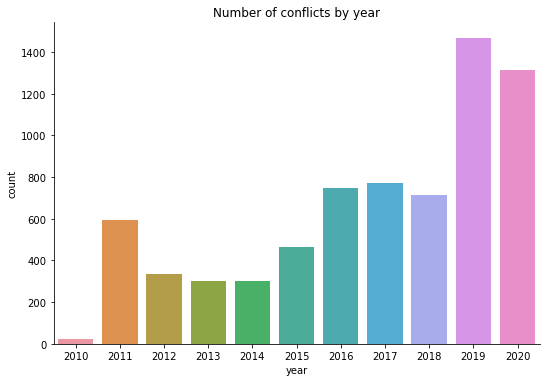

In [18]:
# we form a key value pair and map every string with a value of Tunisia.
tunisia_map = tunisia_filter.map(lambda x: (x[11], x[2]))
rddColumns = ["country","year"]
df = tunisia_map.toDF(rddColumns).toPandas()
df['year'] = pd.to_datetime(df['year'], errors='coerce')
df['year'] = df['year'].dt.year
sns.catplot(x="year", data=df, aspect=1.5,kind="count")
plt.title('Number of conflicts by year in Tunisia')

In [19]:
#we can also check if the RDD is cached or not.
caching = cv.persist().is_cached 
print ( "Words got chached > %s" % (caching))

Words got chached > True


In [42]:
#Show fatalities sum of every interaction number
dataframe.groupBy('INTERACTION').sum('FATALITIES').show()

+-----------+---------------+
|INTERACTION|sum(FATALITIES)|
+-----------+---------------+
|         78|           3073|
|         34|           2428|
|         28|          14558|
|         27|          30110|
|         26|              7|
|         44|          20661|
|         12|          80426|
|         22|           1747|
|         47|          25766|
|         13|          26639|
|         16|           3095|
|         20|            200|
|         40|              0|
|         57|           3090|
|         48|            310|
|         15|           5669|
|         37|          31501|
|         88|             88|
|         17|          18021|
|         35|            330|
+-----------+---------------+
only showing top 20 rows



In [21]:
#show data sorted by Fatalities
dataframe.sort("FATALITIES",ascending=False).show(3)			

+---+----------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+-----------+---------------+-----------+-------+-------+--------+-----------------+--------------------+----------+
|ISO|EVENT_DATE|          EVENT_TYPE|      SUB_EVENT_TYPE|              ACTOR1|ASSOC_ACTOR_1|              ACTOR2|       ASSOC_ACTOR_2|INTERACTION|         REGION|    COUNTRY| ADMIN1| ADMIN2|LOCATION|           SOURCE|               NOTES|FATALITIES|
+---+----------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+-----------+---------------+-----------+-------+-------+--------+-----------------+--------------------+----------+
|728|2011-08-18|Violence against ...|              Attack|Murle Ethnic Mili...|         null|Civilians (South ...|Lou Nuer Ethnic G...|         47| Eastern Africa|South Sudan|Jonglei|   Uror|   Pieri|Small Arms Survey|the Murle attacke...|       7

In [22]:
# Countries With no deaths from conflicts in 2011
sqlContext = SQLContext(sc)
dataframe.registerTempTable("conflicts")	#save the data as a table	
#display Country last updated at 2020-12-07 05:26:14 where Deaths are null.
countries_with_no_deaths= sqlContext.sql("SELECT DISTINCT Country FROM conflicts where EVENT_DATE like '%2011%' and FATALITIES=0")
countries_with_no_deaths.show(10)

+-----------------+
|          Country|
+-----------------+
|             Chad|
|          Senegal|
|          Eritrea|
|         Djibouti|
|           Malawi|
|      Ivory Coast|
|           Rwanda|
|            Sudan|
|          Algeria|
|Equatorial Guinea|
+-----------------+
only showing top 10 rows



In [23]:
# describing fatalities
dataframe.describe('FATALITIES').show()		

+-------+------------------+
|summary|        FATALITIES|
+-------+------------------+
|  count|            170578|
|   mean|1.7503019146666041|
| stddev| 9.874958100076823|
|    min|                 0|
|    max|               750|
+-------+------------------+



In [24]:
dataframe.filter(dataframe.EVENT_DATE.contains("2008")).count()

0

In [25]:
dataframe.filter(dataframe.EVENT_DATE.contains("2011")).count()

8127

In [26]:
dataframe.filter(dataframe.EVENT_DATE.contains("2014")).count()

16547

In [27]:
dataframe.filter(dataframe.EVENT_DATE.contains("2018")).count()

19460

In [28]:
#converting spark dataframe to pandas dataframe
df = dataframe.toPandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170578 entries, 0 to 170577
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ISO             170578 non-null  int32 
 1   EVENT_DATE      170578 non-null  object
 2   EVENT_TYPE      170578 non-null  object
 3   SUB_EVENT_TYPE  170578 non-null  object
 4   ACTOR1          170578 non-null  object
 5   ASSOC_ACTOR_1   44078 non-null   object
 6   ACTOR2          120235 non-null  object
 7   ASSOC_ACTOR_2   31630 non-null   object
 8   INTERACTION     170578 non-null  int32 
 9   REGION          170578 non-null  object
 10  COUNTRY         170578 non-null  object
 11  ADMIN1          170578 non-null  object
 12  ADMIN2          170497 non-null  object
 13  LOCATION        170578 non-null  object
 14  SOURCE          170578 non-null  object
 15  NOTES           170569 non-null  object
 16  FATALITIES      170578 non-null  int32 
dtypes: int32(3), object(14)
memor

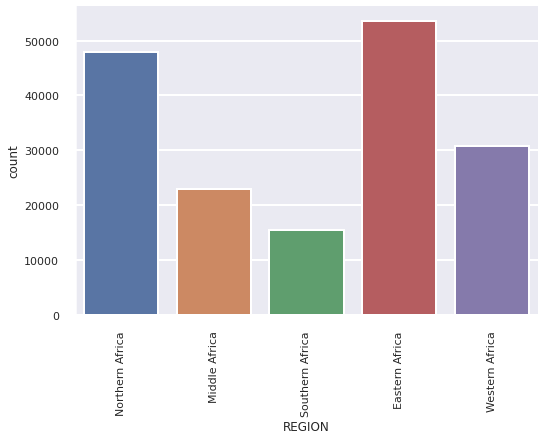

In [29]:
sns.set()
sns.set_context("poster", font_scale=0.5, rc={"lines.linewidth": 15})
ax = sns.catplot(x="REGION", data=df, aspect=1.5,kind="count")
ax.set_xticklabels(rotation=90)

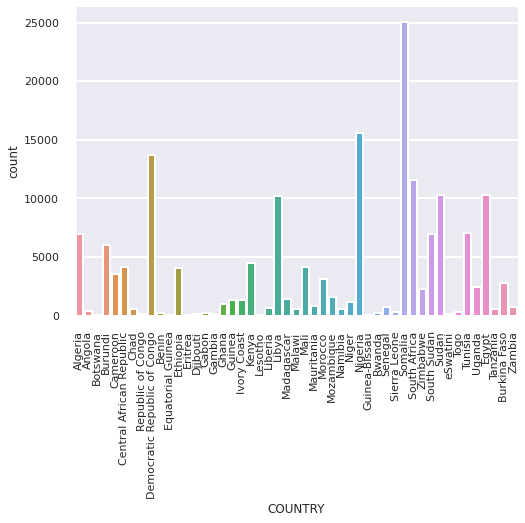

In [30]:
sns.set()
sns.set_context("poster", font_scale=0.5, rc={"lines.linewidth": 15})
ax = sns.catplot(x="COUNTRY", data=df, aspect=1.5,kind="count")
ax.set_xticklabels(rotation=90)

### Couting words occurance in NOTE column

In [45]:
from collections import Counter, defaultdict
import operator
import os, math
import numpy as np
import random
import copy

# Feel free to define your own word_tokenizer instead of this naive 
# implementation. You may also use word_tokenize from nltk library 
# (from nltk import word_tokenize), which works better but slower. 
def remove_stopwords(l):
    STOP  = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 
             'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 
             'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 
             'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 
             'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 
             'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 
             'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 
             'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 
             'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 
             'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 
             'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 
             'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 
             'how', 'further', 'was', 'here', 'than'] 
    l_clean = []
    for i in l: 
        if i not in STOP:
            l_clean.append(i)
    return l_clean 


def word_tokenize(s, clean = False):
    if type(s) != str: 
        return None
    split_l = s.lower().replace('.', '').replace(',', '').replace(';', '').replace(':', '').replace('!', '').replace('?', '').split()
    if clean: 
        clean_l = remove_stopwords(split_l)
        return clean_l
    
    return split_l

VOCAB_SIZE = 5000
class Model:
    def __init__(self, data, clean = False):
        # Vocabulary is a set that stores every word seen in the 
        # training data
        self.vocab_counts = Counter([word for content in data 
                              for word in word_tokenize(content, clean) if word]
                            ).most_common(VOCAB_SIZE-1)
        # word to index mapping
        self.word_to_idx = {k[0]: v+1 for v, k in 
                            enumerate(self.vocab_counts)}
        # all the unknown words will be mapped to index 0
        self.word_to_idx["UNK"] = 0 
        self.vocab = set(self.word_to_idx.keys())
    

In [44]:
#Occurence incuding stop words
df.dropna(subset=['NOTES'], inplace = True)
x_wstopwords = Model(df['NOTES'], False)
x_wstopwords.vocab_counts

[('the', 310550),
 ('in', 199235),
 ('of', 190784),
 ('and', 138813),
 ('a', 126806),
 ('on', 90636),
 ('to', 88962),
 ('were', 49932),
 ('by', 39345),
 ('at', 38469),
 ('was', 38389),
 ('killed', 37588),
 ('forces', 32261),
 ('police', 30656),
 ('an', 30583),
 ('from', 27874),
 ('for', 27044),
 ('with', 27030),
 ('2020', 25424),
 ('two', 23679),
 ('protest', 20562),
 ('against', 20406),
 ('as', 19314),
 ('their', 18052),
 ('people', 17195),
 ('reported', 17018),
 ('al', 16871),
 ('area', 16550),
 ('attacked', 16397),
 ('that', 15889),
 ('attack', 15729),
 ('between', 15723),
 ('after', 15514),
 ('village', 15400),
 ('report]', 15219),
 ('group', 15157),
 ('injured', 14815),
 ('one', 14418),
 ('[size=no', 14397),
 ('shabaab', 14168),
 ('over', 13441),
 ('armed', 13280),
 ('they', 13261),
 ('military', 13155),
 ('no', 12977),
 ('soldiers', 12570),
 ('government', 11539),
 ('security', 11480),
 ('have', 11413),
 ('is', 11334),
 ('members', 10997),
 ('near', 10833),
 ('who', 10727),
 ('to

In [36]:
#Occurence without stop words
x_nstopwords = Model(df['NOTES'], True)
x_nstopwords.vocab_counts

[('killed', 37588),
 ('forces', 32261),
 ('police', 30656),
 ('2020', 25424),
 ('two', 23679),
 ('protest', 20562),
 ('people', 17195),
 ('reported', 17018),
 ('al', 16871),
 ('area', 16550),
 ('attacked', 16397),
 ('attack', 15729),
 ('village', 15400),
 ('report]', 15219),
 ('group', 15157),
 ('injured', 14815),
 ('one', 14418),
 ('[size=no', 14397),
 ('shabaab', 14168),
 ('armed', 13280),
 ('military', 13155),
 ('soldiers', 12570),
 ('government', 11539),
 ('security', 11480),
 ('members', 10997),
 ('near', 10833),
 ('town', 10687),
 ('militants', 10545),
 ('2019', 10454),
 ('three', 10388),
 ('residents', 10196),
 ('unknown', 9831),
 ('shot', 9813),
 ('march', 9698),
 ('protesters', 9480),
 ('state', 9319),
 ('unidentified', 9242),
 ('clashes', 9142),
 ('arrested', 8984),
 ('suspected', 8845),
 ('civilians', 8640),
 ('may', 8520),
 ('several', 8497),
 ('fighters', 8473),
 ('students', 8462),
 ('local', 8315),
 ('clashed', 8288),
 ('killing', 8097),
 ('casualties', 8009),
 ('protest